In [14]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

# import hyperas
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

from tensorflow.keras.preprocessing import timeseries_dataset_from_array
from tensorflow.data import Dataset

import tensorflow as tf

import statsmodels.api as sm

from hyperas import optim
from hyperopt import Trials, tpe


from hyperas import optim
from hyperas.distributions import choice, uniform
from hyperopt import STATUS_OK

In [15]:
df = pd.read_csv("model_data.csv")
df.drop(["Date", "Unnamed: 0"], axis=1, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27140 entries, 0 to 27139
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   temp              27140 non-null  float64
 1   dewp              27140 non-null  float64
 2   slp               27140 non-null  float64
 3   visib             27140 non-null  float64
 4   wdsp              27140 non-null  float64
 5   max               27140 non-null  float64
 6   min               27140 non-null  float64
 7   fog               27140 non-null  float64
 8   rain_drizzle      27140 non-null  float64
 9   snow_ice_pellets  27140 non-null  float64
 10  hail              27140 non-null  float64
 11  thunder           27140 non-null  float64
 12  year sin          27140 non-null  float64
 13  year cos          27140 non-null  float64
dtypes: float64(14)
memory usage: 2.9 MB


In [16]:
df = df.diff(periods=180).dropna().reset_index().drop("index", axis=1)
df

,temp,dewp,slp,visib,wdsp,max,min,fog,rain_drizzle,snow_ice_pellets,hail,thunder,year sin,year cos
0,8.10,16.70,-8.50,-6.10,-2.40,7.00,11.00,1.0,0.0,0.0,0.0,0.0,0.293261,0.036574
1,3.70,9.60,-11.00,-6.80,-4.70,5.10,4.90,1.0,0.0,0.0,0.0,0.0,0.293847,0.031524
2,0.70,3.10,-6.10,-5.40,1.20,-3.10,0.00,1.0,0.0,0.0,0.0,0.0,0.294345,0.026465
3,-16.90,-31.30,8.20,3.20,0.70,-14.90,-18.00,0.0,-1.0,0.0,0.0,0.0,0.294757,0.021398
4,-19.40,-19.20,16.00,0.60,0.90,-25.00,-14.00,0.0,0.0,0.0,0.0,-1.0,0.295082,0.016324
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26955,-5.38,-12.32,4.96,3.44,-2.12,0.80,-12.90,-0.6,-0.4,0.0,0.0,0.0,1.989401,-0.200625
26956,-4.72,-10.10,7.28,1.68,-1.48,-2.44,-8.72,-0.2,0.0,0.0,0.0,0.0,1.985656,-0.234817
26957,-6.36,-11.10,6.84,0.90,-1.12,-3.36,-7.80,-0.8,0.0,-0.2,-0.6,0.0,1.981322,-0.268939
26958,1.64,-2.32,1.86,-0.36,-4.34,12.86,-8.26,-1.0,0.0,0.0,-0.6,0.0,1.976403,-0.302982


In [17]:
# Train, Validation, Test Split
train_df = df[0:int(len(df)*.7)]
val_df = df[int(len(df)*.7):int(len(df)*.9)]
test_df = df[int(len(df)*.9):]


In [18]:
scaler = StandardScaler()
scaler.fit(train_df)


StandardScaler()

In [19]:
train_scaled = scaler.transform(train_df)
val_scaled = scaler.transform(val_df)
test_scaled = scaler.transform(test_df)

In [20]:
# Various window parameters
input_width = 5
label_width = 1
shift = 1
label_columns = None

In [21]:
column_indeces = {name: i for i, name in enumerate(train_df.columns)}
if label_columns is not None:
    label_column_indeces = {name: i for i, name in enumerate(label_columns)}

window_size = input_width + shift

input_slice = slice(0, input_width)
input_indeces = np.arange(window_size)[input_slice]

label_start = window_size - label_width
label_slice = slice(label_start, None)
label_indeces =  np.arange(window_size)[label_slice]

array([24])

In [22]:
def split_window(features):
    inputs = features[:, input_slice, :]
    labels = features[:, label_slice, :]
    if label_columns:
        labels = tf.stack([labels[:, :, column_indeces[name]] for name in label_columns], axis=1)

    inputs.set_shape([None, input_width, None])
    labels.set_shape([None, label_width, None])

    return inputs, labels

In [23]:
# Examples for testing
example_window = tf.stack([np.array(train_scaled[:window_size]),
                        np.array(train_scaled[100:100+window_size]),
                        np.array(train_scaled[200:200+window_size])])
example_inputs, example_labels = split_window(example_window)


In [24]:
example_labels.shape

TensorShape([3, 1, 14])

In [25]:
def make_dataset(data):
    data = np.array(data, dtype=np.float32)
    dset = timeseries_dataset_from_array(
        data=data,
        targets=None,
        sequence_length=window_size,
        sequence_stride=1,
        shuffle=True,
        batch_size=32
    )

    dset = dset.map(split_window)
    return dset

In [26]:
def make_plot(example, model=None, plot_col="temp", max_subplots=3):
    inputs, labels = example
    plt.figure(figsize=(12, 8))
    max_n = min(max_subplots, len(inputs))
    for n in range(max_n):
        plt.subplot(3, 1, n+1)
        plt.ylabel(f"{plot_col}")
        plt.plot(input_indeces,
         inputs[n, :, column_indeces[plot_col]],
         label="Inputs",
         marker=".",
         zorder=10)

        if label_columns:
            label_col_index = label_column_indeces.get(plot_col, None)
        else:
            label_col_index = column_indeces[plot_col]

        if label_col_index is None:
            continue

        plt.scatter(label_indeces, labels[n, :, label_col_index], edgecolors="k", label="Labels", c="#2ca02c", s=64)

        if model:
            predictions = model(inputs)
            plt.scatter(label_indeces, predictions[n:, :, label_col_index],
            marker="X", edgecolors="k", label="Predictions", c="ff7f0e", s=64)
        
        if n==0:
            plt.legend()
        
        plt.xlabel("Days")


In [27]:
def compile_fit(model, train, val, patience=2, max_epochs=10, optimizer="adam"):
    e_stop = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=patience, mode="min")

    model.compile(loss=tf.losses.MeanSquaredError(),
                    optimizer=optimizer,
                    metrics=[tf.metrics.MeanAbsoluteError()])

    history = model.fit(train, epochs=max_epochs, validation_data = val, callbacks=[e_stop])
    return history

In [28]:
model_train = make_dataset(train_scaled)
model_val = make_dataset(val_scaled)
model_test = make_dataset(test_scaled)


In [29]:
def data():
    return model_train, model_val

In [30]:
def make_models(lstm_size, dense_size, dense_layer_num, activation, optimizer):

    model = Sequential()
    model.add(LSTM(lstm_size))
    for i in range(dense_layer_num):
        model.add(Dense(units=dense_size, activation=activation))
    model.add(Dense(14))

    e_stop = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=2, mode="min")
    model.compile(loss=tf.losses.MeanSquaredError(),
                    optimizer=optimizer,
                    metrics=[tf.metrics.MeanAbsoluteError()])

    history = model.fit(model_train, epochs=20, validation_data=model_val, callbacks=[e_stop])

    return {"loss": np.amin(history.history["val_loss"]), "status": STATUS_OK, "model":model}

In [31]:
histories = []
lstm_sizes = [16, 128]
dense_sizes = [50, 200]
dense_layers = [0, 1]
activations = ["relu"]
optimizers = ["adam"]
for lstm_size in lstm_sizes:
    for dense_size in dense_sizes:
        for dense_layer_num in dense_layers:
            for activation in activations:
                for optimizer in optimizers:
                    histories.append(make_models(lstm_size=lstm_size,
                                            dense_size=dense_size,
                                            dense_layer_num=dense_layer_num,
                                            activation=activation,
                                            optimizer=optimizer))
        

Epoch 1/20
590/590 [==============================] - 2s 3ms/step - loss: 1.0056 - mean_absolute_error: 0.7089 - val_loss: 0.7769 - val_mean_absolute_error: 0.6283
Epoch 2/20
590/590 [==============================] - 2s 3ms/step - loss: 1.0005 - mean_absolute_error: 0.6999 - val_loss: 0.7767 - val_mean_absolute_error: 0.6268
Epoch 3/20
590/590 [==============================] - 2s 3ms/step - loss: 1.0001 - mean_absolute_error: 0.6984 - val_loss: 0.7762 - val_mean_absolute_error: 0.6256
Epoch 4/20
590/590 [==============================] - 1s 2ms/step - loss: 1.0000 - mean_absolute_error: 0.6979 - val_loss: 0.7763 - val_mean_absolute_error: 0.6256
Epoch 5/20
590/590 [==============================] - 2s 3ms/step - loss: 1.0000 - mean_absolute_error: 0.6976 - val_loss: 0.7763 - val_mean_absolute_error: 0.6256
Epoch 1/20
590/590 [==============================] - 2s 3ms/step - loss: 1.0013 - mean_absolute_error: 0.7021 - val_loss: 0.7769 - val_mean_absolute_error: 0.6271
Epoch 2/20
590/5

In [43]:
losses = []
for hist in histories:
    losses.append(hist["loss"])
losses

[0.7761617302894592,
 0.7763419151306152,
 0.7762265801429749,
 0.776425838470459,
 0.7759234309196472,
 0.776312530040741,
 0.7761164903640747,
 0.7761567831039429]

In [32]:
lstm_model = Sequential()
lstm_model.add(LSTM(32))

lstm_model.add(Dense(units=14))

In [33]:
lstm_history = compile_fit(lstm_model, model_train, model_val)

Epoch 1/10
590/590 [==============================] - 2s 4ms/step - loss: 1.0029 - mean_absolute_error: 0.7042 - val_loss: 0.7773 - val_mean_absolute_error: 0.6281
Epoch 2/10
590/590 [==============================] - 2s 3ms/step - loss: 1.0003 - mean_absolute_error: 0.6996 - val_loss: 0.7766 - val_mean_absolute_error: 0.6266
Epoch 3/10
590/590 [==============================] - 2s 3ms/step - loss: 1.0002 - mean_absolute_error: 0.6987 - val_loss: 0.7764 - val_mean_absolute_error: 0.6263
Epoch 4/10
590/590 [==============================] - 2s 3ms/step - loss: 1.0000 - mean_absolute_error: 0.6982 - val_loss: 0.7764 - val_mean_absolute_error: 0.6260
Epoch 5/10
590/590 [==============================] - 2s 3ms/step - loss: 1.0000 - mean_absolute_error: 0.6980 - val_loss: 0.7762 - val_mean_absolute_error: 0.6259
Epoch 6/10
590/590 [==============================] - 2s 3ms/step - loss: 0.9998 - mean_absolute_error: 0.6978 - val_loss: 0.7765 - val_mean_absolute_error: 0.6256
Epoch 7/10
590/5

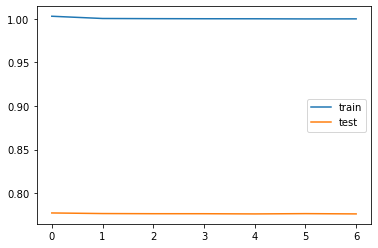

In [34]:
plt.plot(lstm_history.history["loss"], label="train")
plt.plot(lstm_history.history["val_loss"], label="test")
plt.legend()
plt.show()

In [35]:
test_predictions = make_dataset(test_scaled)
test_predictions.as_numpy_iterator()


In [36]:
predictions = lstm_model.predict(make_dataset(test_scaled))
inverse_pred = scaler.inverse_transform(predictions)

In [37]:
output_df = pd.DataFrame(data=inverse_pred, columns=df.columns)

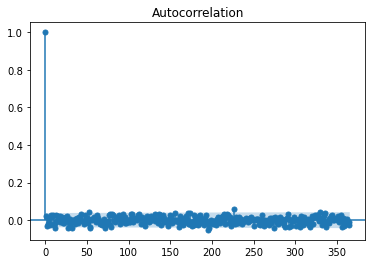

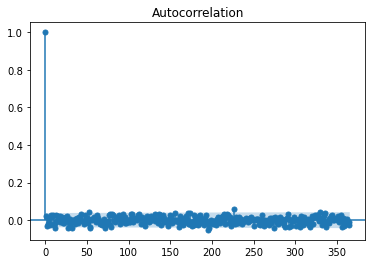

In [38]:
sm.graphics.tsa.plot_acf(output_df["temp"], lags=365)

In [39]:
output_df

,temp,dewp,slp,visib,wdsp,max,min,fog,rain_drizzle,snow_ice_pellets,hail,thunder,year sin,year cos
0,-0.028759,0.036231,-0.052770,-0.014536,0.038219,-0.031854,0.186133,0.002934,0.001523,0.000085,0.000043,-0.002347,0.045963,-0.030668
1,0.032892,0.302198,-0.327389,0.041939,0.039584,0.045359,0.059399,0.004697,0.001205,0.000227,0.000199,-0.008756,0.027202,-0.024020
2,0.984886,0.994712,-0.277049,0.009768,-0.099164,0.910465,0.818199,-0.001530,0.003258,0.001448,0.000436,-0.002746,0.077609,0.031750
3,0.611154,0.770751,-0.107395,0.020753,-0.077830,0.518434,0.367870,-0.001171,-0.000147,0.001443,0.000445,-0.000053,0.074897,0.004270
4,-0.197700,-0.019658,-0.142907,-0.065545,0.056534,-0.258290,-0.041494,0.004344,0.000188,0.000988,0.000365,-0.005079,0.000492,-0.036218
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2686,1.001521,0.889224,-0.411222,-0.022221,0.019990,0.878884,1.142519,0.001321,0.013115,0.001333,0.000178,0.002668,-0.024389,0.071237
2687,0.116272,-0.307580,-0.195308,-0.048122,0.080589,-0.373563,0.141908,-0.009981,0.013398,-0.000435,-0.000023,0.003111,-0.038469,0.030723
2688,1.466486,1.575995,-0.274746,0.095345,-0.066988,1.361611,1.131555,-0.000615,-0.000214,0.001895,0.000604,-0.000715,0.054157,0.058443
2689,2.128528,1.942042,-0.646679,0.121060,-0.046919,1.925775,1.594208,-0.003836,0.004811,0.001254,0.000943,-0.001577,0.020318,0.079107


In [40]:

output_df["test temp"] = np.array(test_df[24:]["temp"], dtype="float32")
resid = output_df["temp"] - output_df["test temp"]
resid

ValueError: Length of values (2672) does not match length of index (2691)

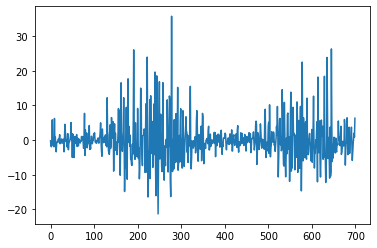